In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on graph (the Graph DGMRF model)
We use the graph model on an image to compare with the convolutional model.

Original code can be found [here](https://github.com/joeloskarsson/graph-dgmrf/blob/main/utils.py). And the article is [here](https://proceedings.mlr.press/v162/oskarsson22a/oskarsson22a.pdf).

In [2]:
from functools import partial
from torch.distributions import MultivariateNormal
import torch
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

2024-07-07 17:43:36.226716: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## First create some observations
We sample a GMRF with Cholesky sampling

In [4]:
H = 50
W = 50
r = 5

In [5]:
from dgmrf.utils import cholesky_sampling_gaussian_field
key, subkey = jax.random.split(key)
source_term = jax.random.normal(subkey, shape=(H * W,))

with jax.default_device(cpu_device):
    x_ori = cholesky_sampling_gaussian_field(r, source_term.flatten(), H, W)

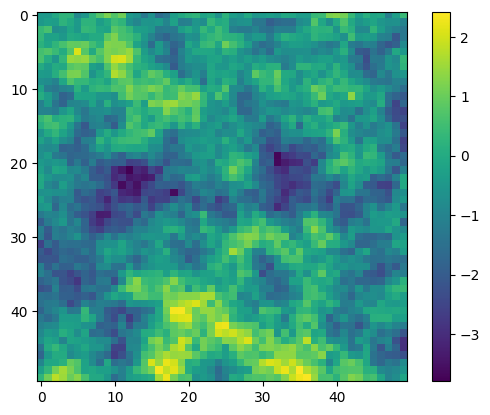

In [6]:
plt.imshow(x_ori)
plt.colorbar()
plt.show()

Add noise over the observations

In [7]:
key, subkey = jax.random.split(key)
true_sigma_noise = 0.4
y = x_ori + jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
N = H * W

In [8]:
mask = jnp.zeros_like(y)

mask = mask.at[5:25, 20:25].set(1)

y = jnp.where(mask == 0, y, 0)

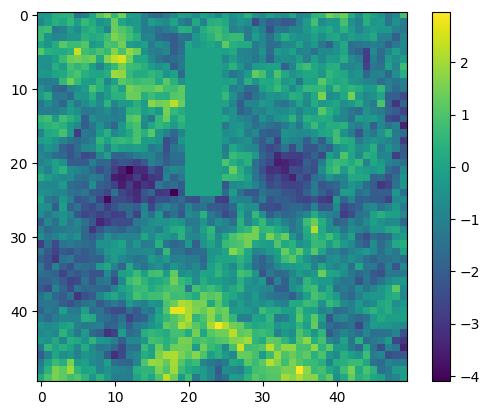

In [9]:
plt.imshow(y)
plt.colorbar()
plt.show()

## Define the DGMRF components

In [10]:
from dgmrf.models import DGMRF, MeanField, FactorizedS
from dgmrf.utils import get_adjacency_matrix_lattice

In [11]:
L = 5
Nq = 5

In [12]:
y = y.flatten()
mask = mask.flatten()

In [13]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(
    subkey,
    L,
    A_D=(get_adjacency_matrix_lattice(H, W), 4 * jnp.ones(H * W)),
    log_det_method="eigenvalues",
    with_bias=True,
    non_linear=False
)

Instanciate the variational distribution we can choose between **Mean-Field** variational distribution and the **factorized distribution** proposed by Oskarsson. While the latter gives slightly better results it is much slower.

In [14]:
key, subkey1, subkey2 = jax.random.split(key, 3)

q_phi = MeanField(N=H * W, key=subkey)
# q_phi = FactorizedS(
#     N=H * W,
#     dgmrf_args=(subkey1, 1),
#     dgmrf_kwargs= {
#         "A_D":(get_adjacency_matrix_lattice(H, W), 4 * jnp.ones(H * W)),
#         "log_det_method":"eigenvalues"
#     },
#     key=subkey2
# )

Define the Model equinox module `(DGMRF, VariationalDistribution, noise_parameter_array)`. This is just a container-like structure

In [15]:
from dgmrf.train import Model
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))

## Variational inference to compute model parameters

In [16]:
n_iter = 1000
lr_graph = 1e-4

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.rprop(lr), 'log_sigma': optax.rprop(0), 'q_phi': optax.rprop(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [17]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_rate = 500
key, subkey = jax.random.split(key, 2)
model, loss_val, opt_state= train_loop(dgmrf_elbo, model, y, n_iter, tx, opt_state, subkey, print_rate, N, Nq, mask=mask)

Iteration 0, loss_value = -1482.9306640625
Iteration 500, loss_value = 50.31658935546875
End of training (iteration 1000), loss_value = 54.16945266723633


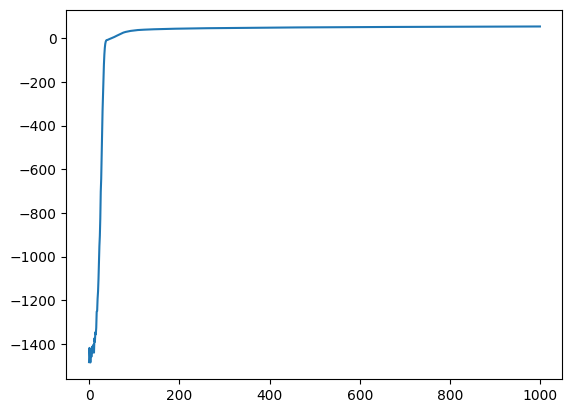

In [18]:
plt.plot(loss_val)
plt.show()

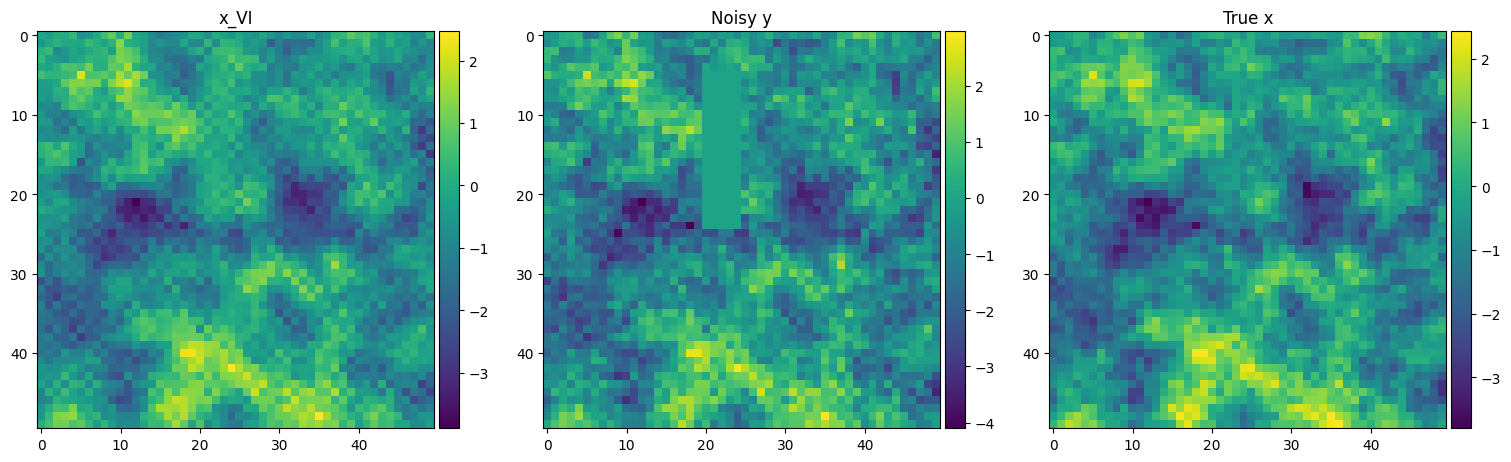

In [19]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(model.posterior.params["nu"].reshape(H, W))
axes[0].set_title("x_VI")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Analyze the parameters that have been learned

We have: $\alpha$, $\beta$, $\gamma$, $b$, $s$ (slope for leakyReLU, not used if nonlinear=False)

In [20]:
from dgmrf.layers import GraphLayer
for l in range(L):
    print(f"Params for layer {l=}", GraphLayer.params_transform(model.dgmrf.layers[l].params))

Params for layer l=0 (Array(0.78617877, dtype=float32), Array(0.78617877, dtype=float32), Array(0.44669592, dtype=float32), Array(0.14357191, dtype=float32), 0.0)
Params for layer l=1 (Array(0.7619347, dtype=float32), Array(-0.7619347, dtype=float32), Array(0.4025157, dtype=float32), Array(0.19650094, dtype=float32), 0.0)
Params for layer l=2 (Array(0.7658827, dtype=float32), Array(0.7658827, dtype=float32), Array(0.41108096, dtype=float32), Array(0.15734532, dtype=float32), 0.0)
Params for layer l=3 (Array(0.6632485, dtype=float32), Array(0.6632485, dtype=float32), Array(0.3885019, dtype=float32), Array(0.08755338, dtype=float32), 0.0)
Params for layer l=4 (Array(0.55168504, dtype=float32), Array(-0.55168504, dtype=float32), Array(0.44265425, dtype=float32), Array(-0.01002111, dtype=float32), 0.0)


## Posterior mean computation with conjugate gradient

[]

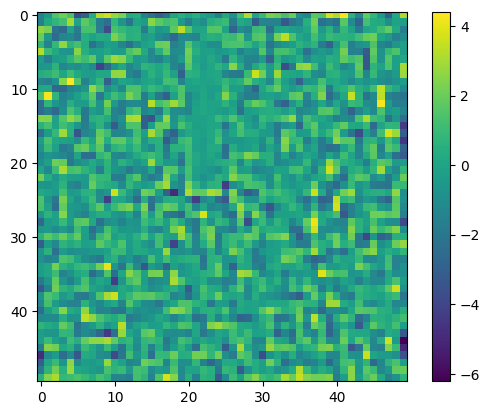

In [21]:
z = model.dgmrf(y)
plt.imshow(z.reshape((H, W)))
plt.colorbar()
plt.plot()

**Note**, on this example, we can still afford the computation of exactly inverting $\tilde{Q}$ to compute exactly the posterior mean without the conjugate gradient:

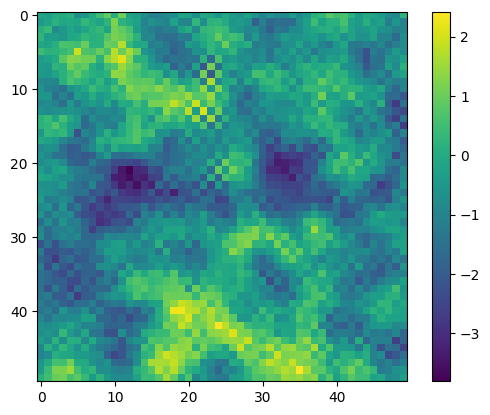

In [22]:
mu_post_exact = model.dgmrf.get_post_mu(
    y,
    model.noise_parameter,
    mask=mask,
    method="exact"
)
plt.imshow(mu_post_exact.reshape((H, W)))
plt.colorbar()
plt.show()

But we can always compute the posterior mean with approximate inversion of $\tilde{Q}$ using conjugate gradient

In [23]:
xpost_mean = model.dgmrf.get_post_mu(y, model.noise_parameter, mask=mask, method="cg")

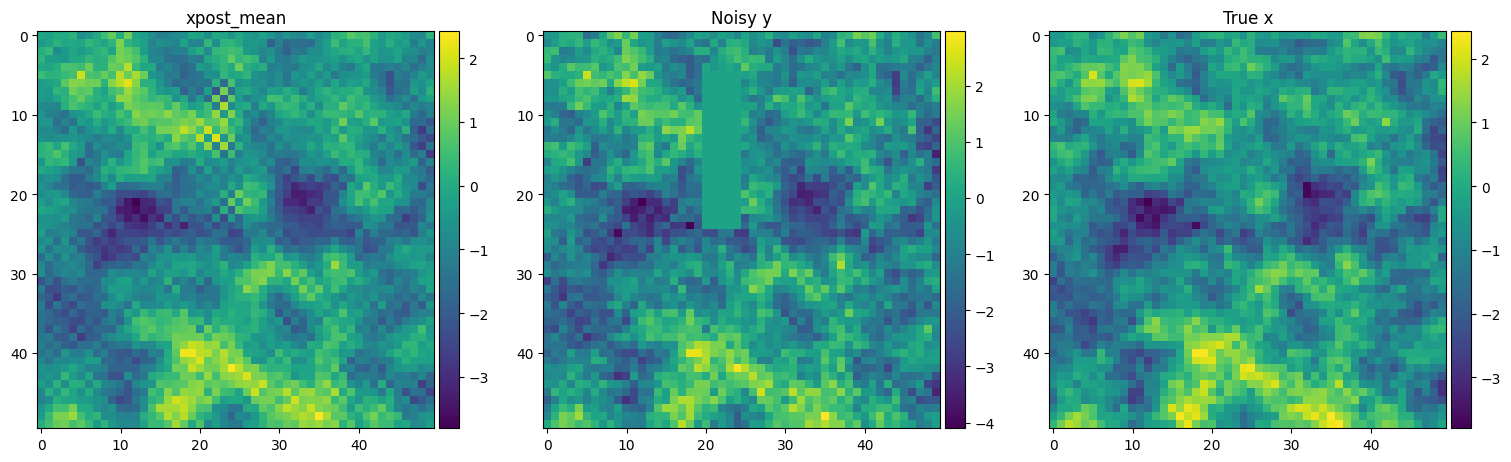

In [24]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(xpost_mean.reshape(H, W))
axes[0].set_title("xpost_mean")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Posterior samples to compute the posterior marginal variances

In [25]:
nb_samples = 50

key, subkey = jax.random.split(key, 2)
x_post_samples = model.dgmrf.posterior_samples(nb_samples, y, model.noise_parameter, subkey, mask=mask)

/tmp/ipykernel_15248/4063010108.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1850x1050 with 6 Axes> than <Figure size 1850x1050 with 11 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')
/tmp/ipykernel_15248/4063010108.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1850x1050 with 6 Axes> than <Figure size 1850x1050 with 12 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')
/tmp/ipykernel_15248/4063010108.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1850x1050 with 6 Axes> than <Figure size 1850x1050 with 13 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')
/tmp/ipykernel_15248/4063010108.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1850x1050 with 6 Axes> than <Figure size 1850x1050 with 14 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='ver

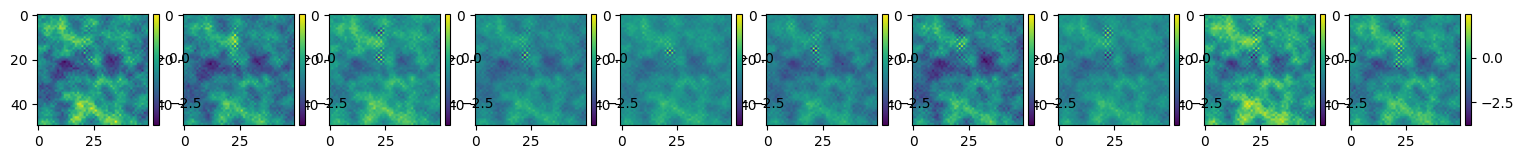

In [26]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(18.5, 10.5)

for i, ax in enumerate(axes):
    ax.imshow(x_post_samples[i].reshape(H, W))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

### Simple MC estimator

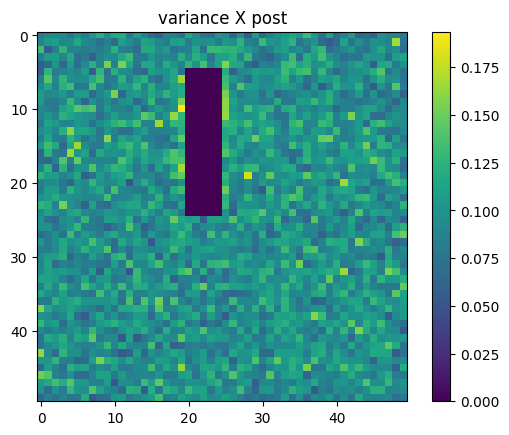

In [27]:
var_x_post_samples = jnp.var(jnp.stack([jnp.where(mask==0,x_post,0) for x_post in x_post_samples], axis=0), axis=0)
plt.imshow(var_x_post_samples.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()

### Simple Rao-Blackwellized Monte Carlo

In [28]:
var_x_post_samples_RBMC = model.dgmrf.rbmc_variance(x_post_samples, model.noise_parameter, mask=mask)

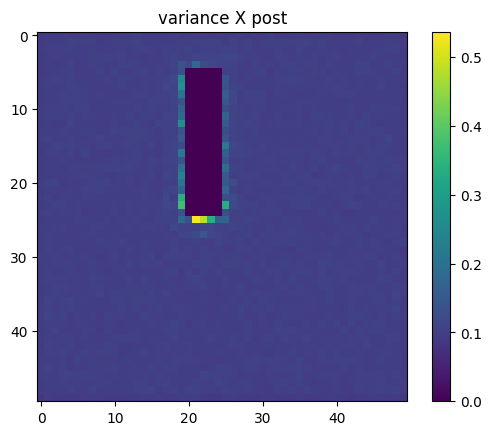

In [29]:
plt.imshow(var_x_post_samples_RBMC.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()